In [1]:
import glob
import pandas as pd
import re
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\naofumi.honda\Anaconda3\envs\py37\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
class Data_holder():
    def __init__(self, stock_prices_raw, train_val_divided, val_flag):
        self.stock_close_price_index = stock_prices_raw.loc[:,'open':'volume'].columns.get_loc('close')
        self.stock_prices = stock_prices_raw.loc[:,'open':'volume'].values
        self.train_val_divided = train_val_divided
        self.val_flag = val_flag
        if self.val_flag != True:
            self.stock_prices = self.stock_prices[:int(self.stock_prices.shape[0]*self.train_val_divided)]
        if self.val_flag == True:
            self.stock_prices = self.stock_prices[int(self.stock_prices.shape[0]*self.train_val_divided):]


    @staticmethod
    def prepare_data(file_source):
        """株価データのcsvファイルをpandas.core.frame.DataFrame形式でloadする関数。

        Args:
            str: csvファイルのuri。

        Return:
            pandas.core.frame.DataFrame: 株価データ。「列名：日付,始値,高値,低値,終値,出来高,取引総額」、「行名：日付」の表。

        """
        stock_data = pd.read_csv(file_source, engine = "python")
        stock_data = stock_data.set_index('date')
        temp = file_source.replace(storage_uri, '')
        temp = re.sub(r'YYYYY', '', temp)
        latest_data = re.sub(r'.csv', '', temp)
        latest_data = [float(x.strip()) for x in latest_data.split(',')]
        temp = pd.DataFrame([latest_data[1:]], columns=stock_data.columns, index=[int(latest_data[0])], dtype=float)
        stock_data = stock_data.append(temp,ignore_index=False)
        return stock_data


    def fragment_normalize_data(self, window_size, predicted_day_num):
        fragment_num = self.stock_prices.shape[0] - window_size - predicted_day_num
        stock_price_flagments = np.zeros((fragment_num, window_size+predicted_day_num, feature_num))
        XXXXX = YYYYY #test時に出力を株価に変換するために必要。

        #正規化
        stock_price_labels = torch.tensor(stock_price_flagments[:, window_size+predicted_day_num-1, self.stock_close_price_index], dtype=torch.float, device=device).view(-1, 1)
        stock_price_flagments = torch.tensor(stock_price_flagments[:, :window_size, :], dtype=torch.float, device=device)

        if self.val_flag != True:
            return stock_price_labels, stock_price_flagments
        if self.val_flag == True:
            return stock_price_labels, stock_price_flagments, XXXXX

In [3]:
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, phase):
        self.sequence = x
        self.label = y
        self.phase = phase


    def __len__(self):
        return len(self.label)


    def __getitem__(self, idx):
        out_data = self.sequence[idx]
        out_label =  self.label[idx]
        return out_data, out_label

In [4]:
class LSTMC_full_connected_layer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
            super().__init__()
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.batch_size = batch_size
            self.lstm = nn.LSTM(input_size=self.input_size,
                                hidden_size=self.hidden_size,
                                num_layers=self.num_layers,
                                batch_first=True
                                )
            self.dense = nn.Linear(hidden_size, 1)


    def forward(self, x_data, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, hidden_layer_size)
        c0 = torch.zeros(self.num_layers, batch_size, hidden_layer_size)

        #隠れ層、cellの内部状態は使用しない。
        lstm_out, (hn, cn) = self.lstm(x_data, (h0, c0))
        linear_out = self.dense(lstm_out[:,-1,:].view(x_data.size(0), -1))
        return torch.sigmoid(linear_out)

In [5]:
def loss_func(pred_value, true_value):
    small_value = 1e-4
    pred_value_flattened = pred_value.view(-1)
    true_value_flattened = true_value.view(-1)
    squared_diff_sum = torch.sum((pred_value_flattened - true_value_flattened)**2)
    loss = (squared_diff_sum + small_value)/(pred_value_flattened.size(0) + small_value)
    return loss


def train_model(dataloaders_dict):
    model = LSTMC_full_connected_layer(feature_num, hidden_layer_size, num_layers)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_train = np.zeros((epochs, 2))
    loss_val = np.zeros((int(epochs/5), 2))

    for i in range(epochs):
        total_loss = 0.0
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                #optimizer.zero_grad() 
                print('（train）')
            else:
                if((i+1) % 5 == 0):
                    model.eval()
                    print('-------------')
                    print('（val）')
                else:
                    continue

            count = 0
            for x, y in dataloaders_dict[phase]:
                count += 1
                with torch.set_grad_enabled(phase == 'train'):
                    y_pred = model(x, batch_size)
                    loss = loss_func(y_pred, y)
                    total_loss += loss.item()
                    if (phase == 'train'):
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

            total_loss /= count
            if phase == 'train':
                loss_train[i, 0] = i+1
                loss_train[i, 1] = total_loss
            if phase == 'val' and (i+1) % 5 == 0:
                loss_val[int((i+1)/5-1), 0] = i+1
                loss_val[int((i+1)/5)-1, 1] = total_loss
            print(f'epoch: {i+1:3} loss: {total_loss:10.8f}')
    return model, loss_train, loss_val

In [6]:
storage_uri = YYYYY
gl = glob.glob(YYYYY)

window_size = Y
feature_num = 5
train_val_divided = 0.7

batch_size = Y
hidden_layer_size = Y
num_layers = 1
epochs = 50

def train_and_test_NN(stock_prices_raw1, stock_prices_raw2, predicted_day_num):
    data_holder_t = Data_holder(stock_prices_raw1, train_val_divided, val_flag=False)
    data_holder_v = Data_holder(stock_prices_raw2, train_val_divided, val_flag=True)

    stock_price_labels_t, stock_price_flagments_t = data_holder_t.fragment_normalize_data(window_size, predicted_day_num)
    stock_price_labels_v, stock_price_flagments_v, XXXXX = data_holder_v.fragment_normalize_data(window_size, predicted_day_num)

    train_dataset = StockDataset(stock_price_flagments_t, stock_price_labels_t, 'train')
    val_dataset = StockDataset(stock_price_flagments_v, stock_price_labels_v, 'val')

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

    model, loss_train, loss_val = train_model(dataloaders_dict)
    test_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=True)
    prices_pred = np.zeros((len(test_dataloader)))
    prices_true = np.zeros((len(test_dataloader)))

    count = 0
    for x, y in test_dataloader:
        y_pred = model(x, batch_size=1).item()*(YYYYY)
        y = y.item()*(YYYYY)
        prices_pred[count] = y_pred
        prices_true[count] = y
        count += 1
    return prices_pred, prices_true, loss_train, loss_val


NameError: name 'Y' is not defined

In [ ]:
stock_prices_raw = Data_holder.prepare_data(gl[0])
drawing_timing = [1, 5, 20, 60, 120]
predicted_day_range = 120
mean_absolute_errors = np.zeros((predicted_day_range))
mean_absolute_price_changing_rate = np.zeros((predicted_day_range))
fig0, ax0 = plt.subplots()



In [ ]:
for i in range(predicted_day_range):
    predicted_day_num = i+1
    prices_pred, prices_true, loss_train, loss_val = train_and_test_NN(stock_prices_raw, stock_prices_raw, predicted_day_num)

    mean_absolute_errors[i] = mean_absolute_error(prices_pred/prices_true, prices_true/prices_true)*100

    tmp = 0
    for j in range(len(prices_true)-predicted_day_num):
        tmp += abs((prices_true[j+predicted_day_num] - prices_true[j]) / prices_true[j])
    mean_absolute_price_changing_rate[i] = tmp / (len(prices_true)-predicted_day_num)*100

    if predicted_day_num in drawing_timing:
        x = np.linspace(predicted_day_num-1, len(prices_true)+predicted_day_num-1, len(prices_pred))
        if predicted_day_num == 1:
            ax0.plot(x, prices_true, label='真値', color='black')
        ax0.plot(x, prices_pred, label=str(predicted_day_num)+'営業日後予測')
        ax0.set_xlabel('営業日')
        ax0.set_ylabel('株価（円）')
        ax0.legend()
        ax0.xaxis.set_minor_locator(tick.MultipleLocator(1))
        ax0.grid(which='minor', linewidth=0.5)
        fig0.savefig('日経平均株価予測.png', format="png", dpi=500)


        fig1, ax1 = plt.subplots()
        ax1.plot(loss_train[:, 0], loss_train[:, 1], label='損失関数（訓練）')
        ax1.plot(loss_val[:, 0], loss_val[:, 1], label='損失関数（検証）')
        ax1.set_xlabel('エポック数')
        ax1.set_title('損失関数（'+str(predicted_day_num)+'営業日後予測）')
        ax1.set_ylim(0.0, 0.2)
        ax1.legend()
        plt.savefig('損失関数'+str(predicted_day_num)+'.png', format="png", dpi=500)


fig = plt.figure()
x = np.linspace(0, predicted_day_range-1, predicted_day_range)
plt.plot(x, mean_absolute_price_changing_rate, label='株価平均絶対変化率', color='black')
plt.plot(x, mean_absolute_errors, label='予測値平均絶対誤差', color='red')
plt.xlabel('n営業日後予測')
plt.ylabel('平均絶対誤差・株価平均絶対変化率（%）')
plt.legend()
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor', linewidth=0.5)
plt.savefig('平均絶対誤差・株価平均絶対変化率（%）.png', format="png", dpi=500)

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import optuna

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.ticker as ticker

# インストール方法 https://tkstock.site/2018/08/22/post-593/
import talib as ta

## 評価関数

In [4]:
def win_loss(Y_test, pred):
    # Series型のデータをデータフレーム化
    test_y2 = pd.DataFrame(Y_test)
    # 予測結果を格納
    test_y2['pred'] = pred

    # 混同行列の各セルを定義
    m1 = len(test_y2[(test_y2['Maguro']==1) & (test_y2['pred']==1)])
    m2 = len(test_y2[(test_y2['Maguro']==1) & (test_y2['pred']==0)])
    m3 = len(test_y2[(test_y2['Maguro']==1) & (test_y2['pred']==-1)])
    m4 = len(test_y2[(test_y2['Maguro']==0) & (test_y2['pred']==1)])
    m5 = len(test_y2[(test_y2['Maguro']==0) & (test_y2['pred']==0)])
    m6 = len(test_y2[(test_y2['Maguro']==0) & (test_y2['pred']==-1)])
    m7 = len(test_y2[(test_y2['Maguro']==-1) & (test_y2['pred']==1)])
    m8 = len(test_y2[(test_y2['Maguro']==-1) & (test_y2['pred']==0)])
    m9 = len(test_y2[(test_y2['Maguro']==-1) & (test_y2['pred']==-1)])

    #　Total取引回数、大勝率、大敗率、の計算
    try:
        mall=m1+m2+m3+m4+m5+m6+m7+m8+m9
        ma=m1+m3+m4+m6+m7+m9
        mb=(m1+m9)/ma
        mc=(m3+m7)/ma
        win_loss_ratio = mb/mc
    except ZeroDivisionError:
        win_loss_ratio = 0
        
    # 各種モデル評価指標出力
    return win_loss_ratio

## data load

In [5]:
df = pd.read_excel('../input/data_RF.xlsx')
print(df.shape)
df.head()

(5470, 111)


Date  eurusd_Open  eurusd_High  eurusd_Low  eurusd_Close  \
0 2000-01-03       1.0050       1.0280      1.0048        1.0262   
1 2000-01-04       1.0240       1.0343      1.0210        1.0308   
2 2000-01-05       1.0293       1.0402      1.0280        1.0314   
3 2000-01-06       1.0320       1.0414      1.0270        1.0319   
4 2000-01-07       1.0324       1.0330      1.0250        1.0289   

   EURUSD_high-low  EURUSD_close-open  EURUSD_close-open_%  \
0           0.0232             0.0212             0.913793   
1           0.0133             0.0068             0.511278   
2           0.0122             0.0021             0.172131   
3           0.0144            -0.0001            -0.006944   
4           0.0080            -0.0035            -0.437500   

   EURUSD_NegativeLine  EURUSD_PositiveLine  ...  deb10y_Close  ptd10y_Open  \
0               0.0002               0.0018  ...           NaN          NaN   
1               0.0030               0.0035  ...           NaN          NaN   
2               0.0013               0.0088  ...           NaN          NaN   
3               0.0049               0.0094  ...           NaN          NaN   
4               0.0039               0.0006  ...           NaN          NaN   

   ptd10y_High  ptd10y_Low  ptd10y_Close  DE_US_10ySpread  GR_DE_10ySpread  \
0          NaN         NaN           NaN              NaN              NaN   
1          NaN         NaN           NaN              NaN              NaN   
2          NaN         NaN           NaN              NaN              NaN   
3          NaN         NaN           NaN              NaN              NaN   
4          NaN         NaN           NaN              NaN              NaN   

   IT_DE_10ySpread  PT_DE_10ySpread  Maguro  
0              NaN              NaN       1  
1              NaN              NaN       0  
2              NaN              NaN       0  
3              NaN              NaN      -1  
4              NaN              NaN       0  

[5 rows x 111 columns]

## 欠損処理

### 欠損率

In [6]:
null_count = df.isnull().sum()
null_rate = null_count / len(df)

null_table = pd.DataFrame({
    '欠損行数': null_count,
    '欠損率': null_rate
})

null_table.sort_values(by='欠損率', ascending=False).head(30)

欠損行数       欠損率
PT_DE_10ySpread  1754  0.320658
ptd10y_Close     1744  0.318830
ptd10y_Low       1744  0.318830
ptd10y_High      1744  0.318830
ptd10y_Open      1744  0.318830
DE_US_10ySpread  1721  0.314625
GR_DE_10ySpread  1627  0.297441
grb10y_Low       1616  0.295430
grb10y_High      1616  0.295430
grb10y_Open      1616  0.295430
grb10y_Close     1616  0.295430
deb10y_Close     1591  0.290859
IT_DE_10ySpread  1591  0.290859
deb10y_Low       1591  0.290859
deb10y_High      1591  0.290859
deb10y_Open      1591  0.290859
itb10y_Close     1581  0.289031
itb10y_Low       1581  0.289031
itb10y_High      1581  0.289031
itb10y_Open      1581  0.289031
shanghai_High     378  0.069104
shanghai_Low      378  0.069104
shanghai_Open     378  0.069104
shanghai_Close    378  0.069104
nikkei_Low        318  0.058135
nikkei_Close      318  0.058135
nikkei_Open       318  0.058135
nikkei_High       318  0.058135
usb10y_Low        200  0.036563
usb10y_Open       200  0.036563

### 欠損補完

In [7]:
# # とりあえず欠損行を全削除
# df_drop = df.dropna(how="any")
# print(df_drop.shape)

In [8]:
# NULLを過去の値で補完
df_drop = df.interpolate(limit_direction='forward', axis=0).dropna(how="any")
print(df_drop.shape)

(3772, 111)


## 特徴量作成/加工
- テクニカル指標の追加
- 変数ごとに有効そうな統計量作成
- 過去の実績値の差分（1週間前との価格差分など）
- 日付の加工（祝日・曜日など）

### テクニカル指標

In [9]:
# テクニカル指標を計算
def calc_technical_indicators(Date, high, low, close, prefix):
    df_x = pd.DataFrame({'Date':Date})

    # 単純移動平均
    df_x['{}_sma5'.format(prefix)] = ta.SMA(close, timeperiod=5)
    df_x['{}_sma25'.format(prefix)] = ta.SMA(close, timeperiod=25)
    df_x['{}_sma50'.format(prefix)] = ta.SMA(close, timeperiod=50)
    df_x['{}_sma200'.format(prefix)] = ta.SMA(close, timeperiod=200)

    # 指数平滑化移動平均
    df_x['{}_ema12'.format(prefix)] = ta.EMA(close, timeperiod=12)
    df_x['{}_ema20'.format(prefix)] = ta.EMA(close, timeperiod=20)
    df_x['{}_ema50'.format(prefix)] = ta.EMA(close, timeperiod=50)
    df_x['{}_ema200'.format(prefix)] = ta.EMA(close, timeperiod=200)

    # MACD (Moving Average Convergence/Divergence)
    macd, macd_sig, macd_hist = ta.MACD(close, fastperiod=12, 
                                            slowperiod=26,
                                            signalperiod=9)
    df_x['{}_macd'.format(prefix)] = macd
    df_x['{}_macd_sig'.format(prefix)] = macd_sig
    df_x['{}_macd_hist'.format(prefix)] = macd_hist

    # RSI (Relative Strength Index)
    df_x['{}_rsi_long'.format(prefix)] = ta.RSI(close, timeperiod=14)
    df_x['{}_rsi_short'.format(prefix)] = ta.RSI(close, timeperiod=7)

    # WILLR (Williams' %R)
    df_x['{}_willr'.format(prefix)] = ta.WILLR(high, low, close, timeperiod=14)

    # Stochastic (STOCH)
    slowk, slowd = ta.STOCH(high, low, close, fastk_period=5, slowk_period=3,
                            slowk_matype=0, slowd_period=3, slowd_matype=0)

    df_x['{}_slowk'.format(prefix)] = slowk
    df_x['{}_slowd'.format(prefix)] = slowd

    # Bolinger Bands (BBANDS)
    u_band, m_band, l_band = ta.BBANDS(close, timeperiod=5,
                                       nbdevup=2, nbdevdn=2, matype=0)

    df_x['{}_u_band'.format(prefix)] = u_band
    df_x['{}_m_band'.format(prefix)] = m_band
    df_x['{}_l_band'.format(prefix)] = l_band

    # ADX, DI+ and DI-
    df_x['{}_adx'.format(prefix)] = ta.ADX(high, low, close,timeperiod=14)

    df_x['{}_DI_plus'.format(prefix)] = ta.PLUS_DI(high, low, close, timeperiod=14)
    df_x['{}_DI_minus'.format(prefix)] = ta.MINUS_DI(high, low, close, timeperiod=14)

    return df_x

In [10]:
# テクニカル指標の計算対象
Date = np.array(df_drop['Date']) 
high = np.array(df_drop['eurusd_High'])
low = np.array(df_drop['eurusd_Low'])
close = np.array(df_drop['eurusd_Close']) 
prefix = 'eurusd'

# テクニカル指標追加
df_technical_indicators = calc_technical_indicators(Date, high, low, close, prefix)
df_drop_add = pd.merge(df_drop
            ,df_technical_indicators
            ,on='Date'
            ,how='left').dropna(how="any")
print(df_drop_add.shape)

(3573, 133)


###  日付の加工

In [11]:
# 日付の年月、曜日（月曜が0, 日曜が6）情報の抽出
# ダミー変数へ変換
df_drop_add =df_drop_add.assign(
#             year=df_drop['Date'].dt.year
            month=df_drop['Date'].dt.month
            ,weekday=df_drop['Date'].dt.dayofweek
            ).pipe(lambda df: pd.get_dummies(df, columns=['month','weekday']))

### 正規化/標準化
非線形のランダムフォレストで正規化とかする必要ある？

### 特徴量の選定
モデルに使う特徴量を決める

## バリデーション
時系列データでランダム分割する場合、翌日のデータがtrainに混ざることもあり過学習しやすいため、時系列の並びを維持したままバリデーションする

In [12]:
# df_drop_add = df_drop_add[df_drop_add['Date'] > dt.datetime(2015,5,1)]
# train,testを分割
X_train, X_test, Y_train, Y_test = train_test_split(df_drop_add.drop('Maguro', axis=1), df_drop_add["Maguro"]
                                                    ,shuffle=False
                                                    ,train_size=0.6)

### trainとtestの範囲可視化

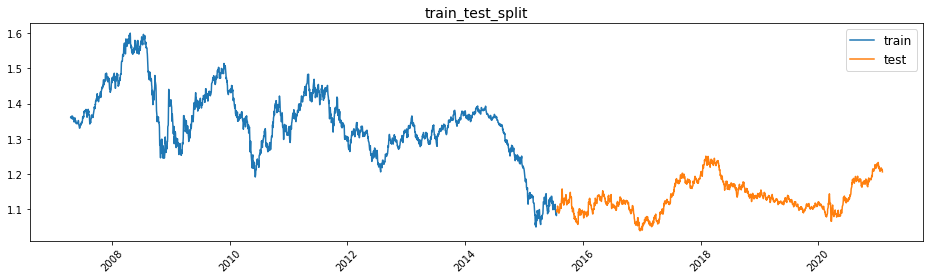

In [13]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(X_train['Date'], X_train['eurusd_Open'], label='train')
ax.plot(X_test['Date'], X_test['eurusd_Open'], label='test')
ax.legend(fontsize=12)
ax.set_title('train_test_split', fontsize=14)
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
ax.xaxis.set_tick_params(rotation=45)

##  モデル作成

In [14]:
# Date削除
X_train.drop('Date', axis=1, inplace=True)
X_test.drop('Date', axis=1, inplace=True)

### デフォルトのパラメータのモデル（ベースライン）

In [37]:
seed = 17
model = RandomForestClassifier(random_state=seed)
model.fit(X_train, Y_train)
pred = model.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(Y_test, pred)))
a, b, c, d, e, f, g, h, i = confusion_matrix(Y_test, pred).ravel()
maguro = a+i
print('maguro検出数: {}'.format(maguro))
print('Big Win/Big Loss Ratio: {}'.format(win_loss(Y_test, pred)))

Accuracy: 0.32517482517482516
maguro検出数: 228
Big Win/Big Loss Ratio: 1.0555555555555556


### optunaを使ったパラメーターチューニング

In [38]:
def objective(trial):
    '''
    trial:set of hyperparameter    
    '''

    # hypyer param（いろいろ試す）
    max_depth = trial.suggest_int('max_depth', 3, 10) 
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'auto', 'log2'])
    min_samples_split = trial.suggest_int('min_samples_split',2,5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1,10)
#     bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
#     max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1,1000)

    # model
    model = RandomForestClassifier(max_depth=max_depth,
                                  n_estimators=1000,
                                  max_features=max_features,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  n_jobs=-1,
                                  verbose=-1 #学習情報を非表示
                                  )

    # fit
    model.fit(X_train, Y_train)

    # eva
    pred = model.predict(X_test)
    # score = accuracy_score(Y_test, pred) 

#     マグロを検出した件数が最も多いパラメータを評価
#     a, b, c, d, e, f, g, h, i = confusion_matrix(Y_test, pred).ravel()
#     maguro = a+i
#     return maguro

    # Big Win/Big Loss Ratioが最も大きいパラメータを評価
    win_loss_ratio = win_loss(Y_test, pred)
    return win_loss_ratio

# パラメーターチューニングを実行
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=17)
                            ,direction='maximize')

study.optimize(func=objective # 実行する関数
               ,n_trials=30 # 試行回数
               ,timeout=30 # 与えられた秒数後に学習を中止 default=None
               ,n_jobs=-1 # 並列実行するjob数
               
              )

print('ベストパラメータ: {}'.format(study.best_params))
# print('maguro検出数: {}'.format(study.best_value))
print('Big Win/Big Loss Ratio: {}'.format(study.best_value))

best_param = study.best_params

[I 2021-03-04 19:09:51,204] A new study created in memory with name: no-name-f3fe6d3a-c501-45e8-bafb-3dbf0305d022
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed

[I 2021-03-04 19:10:19,554] Trial 5 finished with value: 1.198924731182796 and parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 1 with value: 1.4155844155844157.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapse

ベストパラメータ: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 6}
Big Win/Big Loss Ratio: 1.4155844155844157


In [39]:
# ベストパラメータにてモデル作成
seed = 17
model = RandomForestClassifier(**best_param, random_state=seed)
model.fit(X_train, Y_train)
pred = model.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(Y_test, pred)))
a, b, c, d, e, f, g, h, i = confusion_matrix(Y_test, pred).ravel()
maguro = a+i
print('maguro検出数: {}'.format(maguro))
print('Big Win/Big Loss Ratio: {}'.format(win_loss(Y_test, pred)))

Accuracy: 0.4461538461538462
maguro検出数: 133
Big Win/Big Loss Ratio: 1.3711340206185567


In [40]:
# モデル保存
pd.to_pickle(model, '../output/rf.pkl')

## 精度評価

### 混同行列

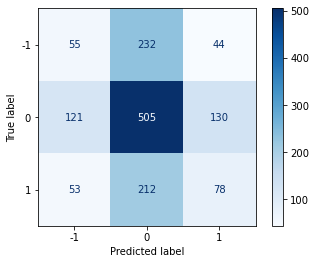

In [41]:
plot_confusion_matrix(model, X_test, Y_test,cmap='Blues')

### win/loss

In [42]:
# Series型のデータをデータフレーム化
test_y2 = pd.DataFrame(Y_test)
# 予測結果を格納
test_y2['pred'] = model.predict(X_test)

# 混同行列の各セルを定義
m1 = len(test_y2[(test_y2['Maguro']==1) & (test_y2['pred']==1)])
m2 = len(test_y2[(test_y2['Maguro']==1) & (test_y2['pred']==0)])
m3 = len(test_y2[(test_y2['Maguro']==1) & (test_y2['pred']==-1)])
m4 = len(test_y2[(test_y2['Maguro']==0) & (test_y2['pred']==1)])
m5 = len(test_y2[(test_y2['Maguro']==0) & (test_y2['pred']==0)])
m6 = len(test_y2[(test_y2['Maguro']==0) & (test_y2['pred']==-1)])
m7 = len(test_y2[(test_y2['Maguro']==-1) & (test_y2['pred']==1)])
m8 = len(test_y2[(test_y2['Maguro']==-1) & (test_y2['pred']==0)])
m9 = len(test_y2[(test_y2['Maguro']==-1) & (test_y2['pred']==-1)])

#　Total取引回数、大勝率、大敗率、の計算
mall=m1+m2+m3+m4+m5+m6+m7+m8+m9
ma=m1+m3+m4+m6+m7+m9
mb=(m1+m9)/ma
mc=(m3+m7)/ma

# 各種モデル評価指標出力
print('＜基本情報＞')
print('Total days',mall)
print('Total Trade times',ma)
print('Total Trade frequency',ma/mall)
print('Trade times per year',ma/(mall/250))
print('Trade times per month',250*ma/mall/12)
print('Trade times per week',250*ma/mall/12/4)
print('Trade times per day',250*ma/mall/12/20)
print('＜勝敗割合＞')
print('Big Win rate',mb)
print('Big Loss rate',mc)
print('Small trade',(m4+m6)/ma)
print('Big Win/Big Loss Ratio',mb/mc)

＜基本情報＞
Total days 1430
Total Trade times 481
Total Trade frequency 0.33636363636363636
Trade times per year 84.0909090909091
Trade times per month 7.007575757575758
Trade times per week 1.7518939393939394
Trade times per day 0.3503787878787879
＜勝敗割合＞
Big Win rate 0.2765072765072765
Big Loss rate 0.20166320166320167
Small trade 0.5218295218295218
Big Win/Big Loss Ratio 1.3711340206185567


### トレードのシミュレーション

In [43]:
def trade_simulation(dfx,leverage,start_balance):
    i = 0
    for index,item in dfx.iterrows():
        # 1万EUR（1枚）取引に必要な証拠金
        dfx.loc[index,'margin_per_eur'] = item['eurusd_Close']*item['usdjpy_Close']*10000/leverage

        # 残高
        if i <= 1:
            dfx.loc[index,'balance'] = start_balance 
        else:
            dfx.loc[index,'balance'] = dfx.loc[index-1,'balance'] + dfx.loc[index-1,'profit_loss']

        # 枚数
        num = dfx.loc[index,'balance']/2/dfx.loc[index,'margin_per_eur']
        if num>100:
            num = 100
        dfx.loc[index,'num']  = num

        # 必要証拠金
        dfx.loc[index,'margin']  = dfx.loc[index,'margin_per_eur']*dfx.loc[index,'num']

        # ポジションメイク後投資余力
        dfx.loc[index,'capacity']  = dfx.loc[index,'balance']-dfx.loc[index,'margin']

        # レート変動耐性
        dfx.loc[index,'rate_fluctuation_tolerance'] = dfx.loc[index,'capacity']/(dfx.loc[index,'num']*10000)

        # 損益
        if i <= 1:
            dfx.loc[index,'profit_loss'] = 0 
        else:
            dfx.loc[index,'profit_loss'] = dfx.loc[index-2,'pred']*(dfx.loc[index,'eurusd_Close']-dfx.loc[index-2,'eurusd_Close'])*dfx.loc[index-2,'num']*10000*dfx.loc[index,'usdjpy_Close']

        i = i+1
    return dfx

In [44]:
## testデータの予測結果に説明変数を結合
# Series型のデータをデータフレーム化
test_y2 = pd.DataFrame(Y_test)
test_y2['pred'] = model.predict(X_test)

# 予測結果保存
col = ['Date','eurusd_Open', 'eurusd_High', 'eurusd_Low', 'eurusd_Close', 'usdjpy_Close', 'Maguro', 'pred']
df_test_result = pd.merge(df_drop_add, test_y2['pred'], left_index=True, right_index=True)[col]


## trainデータの予測結果に説明変数を結合
# Series型のデータをデータフレーム化
train_y2 = pd.DataFrame(Y_train)
train_y2['pred'] = model.predict(X_train)

# 予測結果保存
col = ['Date','eurusd_Open', 'eurusd_High', 'eurusd_Low', 'eurusd_Close', 'usdjpy_Close', 'Maguro', 'pred']
df_train_result = pd.merge(df_drop_add, train_y2['pred'], left_index=True, right_index=True)[col]


#### Back test

初日: 2007-04-20 00:00:00
最終日: 2021-02-02 00:00:00
最終日時点の残高: 465994211
儲け: 464994211


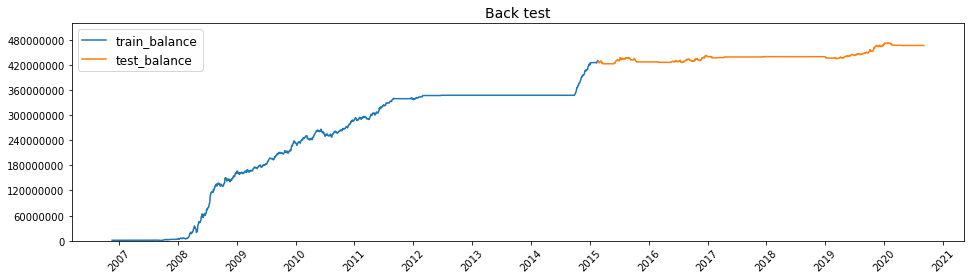

In [45]:
# レバレッジ倍数
leverage = 25
# スタート時の残高
start_balance = 1000000

# 損益計算
df_train_result['is_train'] = True
df_test_result['is_train'] = False
df_concat = pd.concat([df_train_result, df_test_result])

df_back_test = trade_simulation(df_concat,leverage,start_balance)
df_back_test.to_csv('../output/df_back_test.csv', encoding='cp932',index=True)

# Back test時の残高可視化
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(df_concat[df_back_test['is_train']]['Date'], df_back_test[df_back_test['is_train']]['balance'], label='train_balance')
ax.plot(df_concat[~df_back_test['is_train']]['Date'], df_back_test[~df_back_test['is_train']]['balance'], label='test_balance')
ax.legend(fontsize=12)
ax.set_title('Back test', fontsize=14)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False) 
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_ylim(0, df_back_test['balance'].max() + df_back_test['balance'].max()*0.1)
# ax.yaxis.set_ticks(np.arange(0, df_back_test['balance'].max() + 1000000, 500000))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelrotation=45)

print('初日: {}'.format(df_back_test.iloc[0]['Date']))
print('最終日: {}'.format(df_back_test.iloc[-1]['Date']))
print('最終日時点の残高: {}'.format(df_back_test.iloc[-1]['balance'].astype(int)))
print('儲け: {}'.format(df_back_test.iloc[-1]['balance'].astype(int)-start_balance))

#### Forward test

初日: 2015-07-23 00:00:00
最終日: 2021-02-02 00:00:00
最終日時点の残高: 3684841
儲け: 2684841


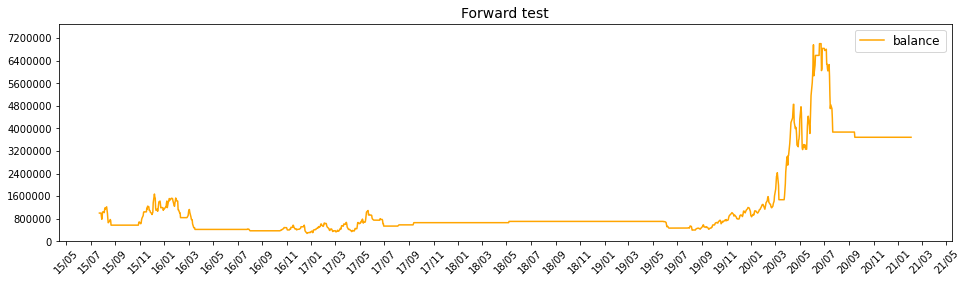

In [46]:
# レバレッジ倍数
leverage = 25
# スタート時の残高
start_balance = 1000000
# 損益計算
df_forward_test = trade_simulation(df_test_result,leverage,start_balance)
df_forward_test.to_csv('../output/df_forward_test.csv', encoding='cp932',index=True)

# Forward test時の残高可視化
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(df_forward_test['Date'], df_forward_test['balance'], label='balance', color='orange')
ax.legend(fontsize=12)
ax.set_title('Forward test', fontsize=14)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False) 
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_ylim(0, df_forward_test['balance'].max() + df_forward_test['balance'].max()*0.1)
# ax.yaxis.set_ticks(np.arange(0, 5000001, 500000))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
ax.tick_params(axis='x', labelrotation=45)

print('初日: {}'.format(df_forward_test.iloc[0]['Date']))
print('最終日: {}'.format(df_forward_test.iloc[-1]['Date']))
print('最終日時点の残高: {}'.format(df_forward_test.iloc[-1]['balance'].astype(int)))
print('儲け: {}'.format(df_forward_test.iloc[-1]['balance'].astype(int)-start_balance))

### feature_importance

feature_names  feature_importance
45          dow_Close            0.057224
71          dax_Close            0.046197
43           dow_High            0.038021
42           dow_Open            0.032429
83          vix_Close            0.026301
44            dow_Low            0.024674
46         dow_Volume            0.021650
69           dax_High            0.019116
111     eurusd_sma200            0.017924
68           dax_Open            0.017706
81   platinum_OpenInt            0.016865
50       nikkei_Close            0.016140
51      shanghai_Open            0.016099
49         nikkei_Low            0.015951
70            dax_Low            0.015561
48        nikkei_High            0.014660
113      eurusd_ema50            0.014494
52      shanghai_High            0.013037
125     eurusd_l_band            0.012796
53       shanghai_Low            0.012693

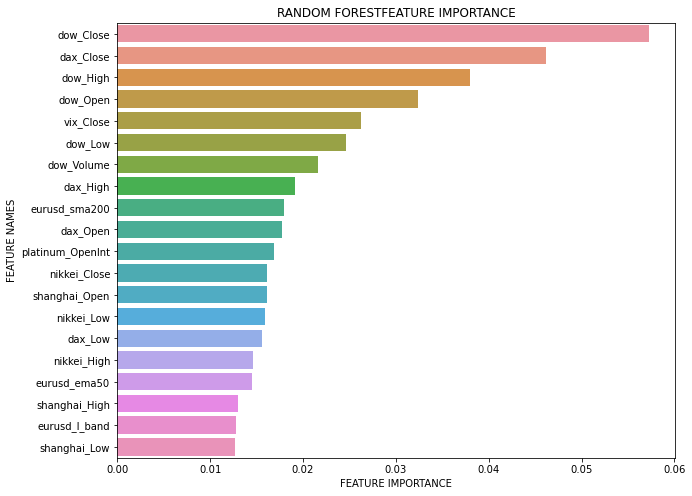

In [47]:
def plot_feature_importance(importance,names):
    
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    return fi_df

# 重要な変数トップ20を取得
fi_df = plot_feature_importance(model.feature_importances_,X_train.columns)
fi_df = fi_df.head(20)

# Define size of bar plot
plt.figure(figsize=(10,8))
# Plot Searborn bar chart
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
# Add chart labels
plt.title('RANDOM FOREST' + 'FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

display(fi_df)